In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Input,Concatenate
from keras.models import Model
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_lstm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/15-02-2022/data.csv', sep=';', decimal=',', index_col=False)

In [ ]:
df_tabular = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/15-02-2022/data.csv', sep=';', decimal=',', index_col=False)

In [ ]:
df_tabular.head()

,municipio,codEstacao,uf,nomeEstacao,latitude,longitude,datahora,valorMedida
0,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 00:10:00.0,0.0
1,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 01:10:00.0,0.0
2,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 02:10:00.0,0.0
3,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 03:10:00.0,0.0
4,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 04:10:00.0,0.0


In [ ]:
df_tabular = df_tabular[["latitude", "longitude"]]

In [ ]:
df_tabular.shape

(12994, 2)

In [ ]:
df_lstm.head()

,municipio,codEstacao,uf,nomeEstacao,latitude,longitude,datahora,valorMedida
0,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 00:10:00.0,0.0
1,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 01:10:00.0,0.0
2,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 02:10:00.0,0.0
3,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 03:10:00.0,0.0
4,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,-43.223916,-22.524907,2022-02-01 04:10:00.0,0.0


In [ ]:
df_lstm.drop(["latitude", "longitude"], axis = 1, inplace = True)

In [ ]:
df_lstm.head()

,municipio,codEstacao,uf,nomeEstacao,datahora,valorMedida
0,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,2022-02-01 00:10:00.0,0.0
1,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,2022-02-01 01:10:00.0,0.0
2,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,2022-02-01 02:10:00.0,0.0
3,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,2022-02-01 03:10:00.0,0.0
4,PETRÓPOLIS,330390601G,RJ,Quitandinha - Geo,2022-02-01 04:10:00.0,0.0


In [ ]:
df_lstm["nomeEstacao"].count

<bound method Series.count of 0        Quitandinha - Geo
1        Quitandinha - Geo
2        Quitandinha - Geo
3        Quitandinha - Geo
4        Quitandinha - Geo
               ...        
12989            Vila Rica
12990            Vila Rica
12991            Vila Rica
12992            Vila Rica
12993            Vila Rica
Name: nomeEstacao, Length: 12994, dtype: object>

In [ ]:
temp_pattern = 10 #quantas medidas passadas serão usadas para prever as medidas para frente
NumeroDeModelos = 1 #atributos utilizados

In [ ]:
#fizemos este para eliminar os 10 primeiros passos de cada estação
def ajustarTensor(x,temp_pattern):
  listaX = []
  listaY = []
  for i in range(x.shape[0] - temp_pattern):
    listaX.append(x[i:(i+temp_pattern)])
    listaY.append(x[i+temp_pattern])
  for i in range(len(listaX)):
    listaX[i] = (np.expand_dims(listaX[i], axis=0))
  return listaX, listaY

In [ ]:
#garantir que fique ordenado e estao medindo a mesma estação sempre
X = []
Y = []

for i in df_lstm["nomeEstacao"].unique():
  x = df_lstm[df_lstm['nomeEstacao']==i]['valorMedida'].values
  listaX, listaY = ajustarTensor(x,temp_pattern)
  X.append(listaX)
  Y.append(listaY)

In [ ]:
X[0][0].shape

(1, 10)

In [ ]:
#transforma a lista de listas em uma unica lista de arrays no X
for i in range(len(X)):
  X[i] = np.concatenate(X[i],axis=0)

In [ ]:
#transforma a lista de listas em uma unica lista de arrays no X
for i in range(len(Y)):
  Y[i] = np.array(Y[i])

In [ ]:
#colapsar a lista de arrays em um único array em X
X = np.concatenate(X)

In [ ]:
#colapsar a lista de arrays em um único array em X
Y = np.concatenate(Y)

In [ ]:
np.array(listaY).shape

(619,)

In [ ]:
X.shape

(12784, 10)

In [ ]:
df_tabular.shape

(12994, 2)

In [ ]:
df_unico = df_tabular[["latitude", "longitude"]].drop_duplicates()

In [ ]:
df_unico = df_unico.values

In [ ]:
df_unico.shape

(21, 2)

In [ ]:
#garantir q a informação bate com o dataset (tabular)
lista_filtro = []

for i in range(df_unico.shape[0]):
  filtro = df_tabular[np.logical_and(df_tabular["latitude"]== df_unico[i,0], df_tabular["longitude"]== df_unico[i,1] )]
  tabela,_ = ajustarTensor(filtro.values,temp_pattern)
  lista_filtro.append(tabela)

In [ ]:
lista_filtro[0][0].shape

(1, 10, 2)

In [ ]:
for i in range(len(lista_filtro)):
  lista_filtro[i] = np.concatenate(lista_filtro[i],axis=0)

In [ ]:
lista_filtro = np.concatenate(lista_filtro, axis=0)

In [ ]:
lista_filtro.shape

(12784, 10, 2)

In [ ]:
lista_filtro = lista_filtro[:,-1,:]

In [ ]:
X.shape

(12784, 10)

In [ ]:
X = np.expand_dims(X, axis=-1)

In [ ]:
X_train, X_test, y_train, y_test, tabular_train, tabular_test = train_test_split(X, Y, lista_filtro, train_size=0.8)

In [ ]:
lstm_input=Input(shape=X_train.shape[1:]) 
from keras.layers import LSTM, Dense
Camada_l=LSTM(20,return_sequences=True)(lstm_input)
Camada_l=LSTM(10)(Camada_l)

In [ ]:
Modelo_l = Model(lstm_input,Camada_l)

In [ ]:
Modelo_l.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 20)            1760      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1240      
                                                                 
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
ch=ModelCheckpoint('Pesos.h5',save_best_only=True)

In [ ]:
def RelativeError(y_true,y_pred):
  import keras.backend as K
  epislon=1e-8
  y_true=y_true+epislon
  Erro=100*K.mean(K.abs(  (y_true-y_pred)/y_true))
  return(Erro)

In [ ]:
tabular_input=Input(shape=df_tabular.shape[1:])
Camada_t=Dense(128)(tabular_input)
Camada_t=Flatten()(Camada_t)
Camada_t=Dense(64)(Camada_t)

In [ ]:
Modelo_t = Model(tabular_input,Camada_t)

In [ ]:
Modelo_t.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
Total params: 8,640
Trainable params: 8,640
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Juncao=Concatenate()([Camada_l,Camada_t])
Conjunto=Dense(32,activation='relu')(Juncao)
Saida=Dense(1,activation='linear')(Conjunto)

In [ ]:
Modelo_Multimodal=Model([lstm_input,tabular_input],[Saida])

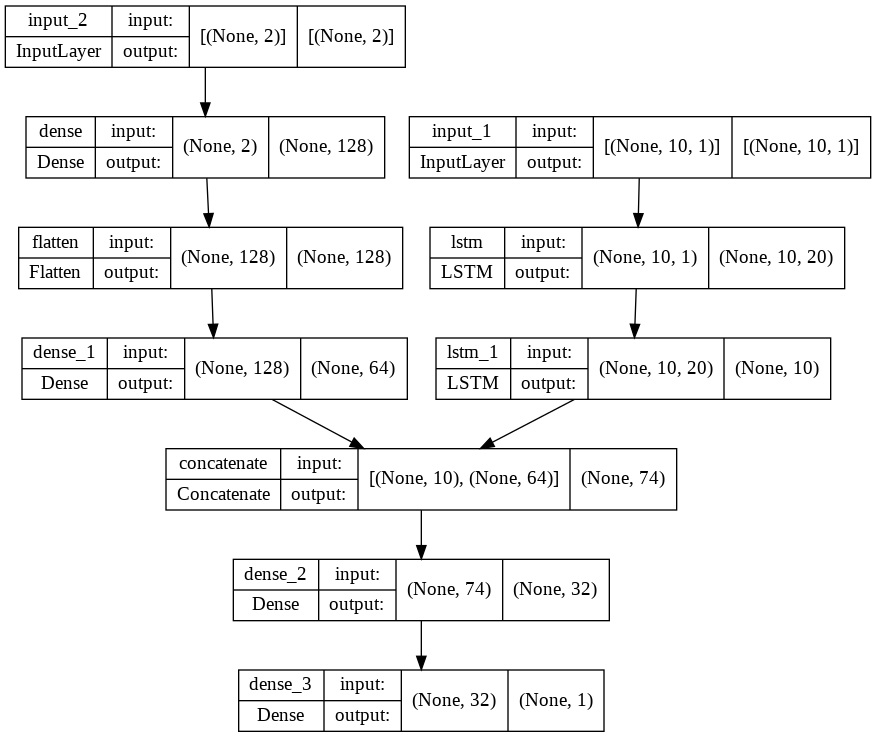

In [ ]:
plot_model(Modelo_Multimodal,show_shapes=True)

In [ ]:
Modelo_Multimodal.compile(loss='mse',optimizer='adam')

In [ ]:
X_train = np.array(X_train)
tabular_train = np.array(tabular_train)

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
type(tabular_train)

numpy.ndarray

In [ ]:
y_train.shape

(10227,)

In [ ]:
X_train.shape

(10227, 10, 1)

In [ ]:
#lista_lstm = list(X_train.shape[1:])
#X_train = np.array(lista_lstm)
#tabular_train = np.array(tabular_train)

In [ ]:
Modelo_Multimodal.fit([X_train,tabular_train],y_train,epochs=1,verbose=1,validation_split=0.3,callbacks=[ch])

224/224 [==============================] - 16s 26ms/step - loss: 2.2956 - val_loss: 1.5577


In [ ]:
df_tabular[0:1]

,Latitude,Longitude
0,-22.54317,-43.266418


In [ ]:
x = df_tabular[["Latitude", "Longitude"]].values

In [ ]:
x

array([[-22.54317041, -43.26641772],
       [-22.54317041, -43.2664635 ],
       [-22.54317041, -43.26650927],
       ...,
       [-22.54378697, -43.26696703],
       [-22.54378697, -43.26701281],
       [-22.54378697, -43.26705859]])

In [ ]:
#df_lstm[['datahora']] == '2022-02-01 00:10:00.0'
y = df_lstm[df_lstm['datahora']=='2022-02-01 00:10:00.0']['valorMedida'].values
y

array([0., 0., 0., 0., 0.])

primeiro instante d tempo (lstm), no primeiro valor unico (tabular)

In [ ]:
amostra = X_train[100:101] #(mesmo indice referente)
amostra

IndexError: ignored

In [ ]:
amostra_tabular = tabular_train[1:1] #(mesmo indice referente)
amostra_tabular

array([], shape=(0, 2), dtype=float64)

In [ ]:
#
lista_prev = []

for i in range(0, 10):
  aux = amostra_tabular
  aux[:,0] = aux[:,0] + i
  aux[:,1] = aux[:,1] + i
  previsao = Modelo_Multimodal.predict([amostra, aux])#aux tem UM par lat long
  lista_prev.append(previsao)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
lista_prev

[array([[-0.10778461]], dtype=float32),
 array([[-0.08388083]], dtype=float32),
 array([[-0.03607888]], dtype=float32),
 array([[0.03562368]], dtype=float32),
 array([[0.1312289]], dtype=float32),
 array([[0.25073385]], dtype=float32),
 array([[0.3459597]], dtype=float32),
 array([[0.23762706]], dtype=float32),
 array([[-2.0645502]], dtype=float32),
 array([[-4.870545]], dtype=float32)]

In [ ]:
#localização dos centroides
x = np.array([
        [(-22.54317041, -43.26641772), (-22.54318803, -43.26641772), (-22.54320564, -43.26641772), (-22.54322326, -43.26641772), (-22.54324087, -43.26641772), (-22.54325849, -43.26641772), (-22.54327611, -43.26641772), (-22.54329372, -43.26641772), (-22.54331134, -43.26641772), (-22.54332895, -43.26641772), (-22.54334657, -43.26641772), (-22.54336419, -43.26641772), (-22.54338180, -43.26641772), (-22.54339942, -43.26641772), (-22.54341703, -43.26641772), (-22.54343465, -43.26641772), (-22.54345227, -43.26641772), (-22.54346988, -43.26641772), (-22.54348750, -43.26641772), (-22.54350511, -43.26641772), (-22.54352273, -43.26641772), (-22.54354035, -43.26641772), (-22.54355796, -43.26641772), (-22.54357558, -43.26641772), (-22.54359319, -43.26641772), (-22.54361081, -43.26641772), (-22.54362843, -43.26641772), (-22.54364604, -43.26641772), (-22.54366366, -43.26641772), (-22.54368127, -43.26641772), (-22.54369889, -43.26641772), (-22.54371651, -43.26641772), (-22.54373412, -43.26641772), (-22.54375174, -43.26641772), (-22.54376935, -43.26641772), (-22.54378697, -43.26641772)], 

        [(-22.54317041, -43.26646350), (-22.54318803, -43.26646350), (-22.54320564, -43.26646350), (-22.54322326, -43.26646350), (-22.54324087, -43.26646350), (-22.54325849, -43.26646350), (-22.54327611, -43.26646350), (-22.54329372, -43.26646350), (-22.54331134, -43.26646350), (-22.54332895, -43.26646350), (-22.54334657, -43.26646350), (-22.54336419, -43.26646350), (-22.54338180, -43.26646350), (-22.54339942, -43.26646350), (-22.54341703, -43.26646350), (-22.54343465, -43.26646350), (-22.54345227, -43.26646350), (-22.54346988, -43.26646350), (-22.54348750, -43.26646350), (-22.54350511, -43.26646350), (-22.54352273, -43.26646350), (-22.54354035, -43.26646350), (-22.54355796, -43.26646350), (-22.54357558, -43.26646350), (-22.54359319, -43.26646350), (-22.54361081, -43.26646350), (-22.54362843, -43.26646350), (-22.54364604, -43.26646350), (-22.54366366, -43.26646350), (-22.54368127, -43.26646350), (-22.54369889, -43.26646350), (-22.54371651, -43.26646350), (-22.54373412, -43.26646350), (-22.54375174, -43.26646350), (-22.54376935, -43.26646350), (-22.54378697, -43.26646350)], 

        [(-22.54317041, -43.26650927), (-22.54318803, -43.26650927), (-22.54320564, -43.26650927), (-22.54322326, -43.26650927), (-22.54324087, -43.26650927), (-22.54325849, -43.26650927), (-22.54327611, -43.26650927), (-22.54329372, -43.26650927), (-22.54331134, -43.26650927), (-22.54332895, -43.26650927), (-22.54334657, -43.26650927), (-22.54336419, -43.26650927), (-22.54338180, -43.26650927), (-22.54339942, -43.26650927), (-22.54341703, -43.26650927), (-22.54343465, -43.26650927), (-22.54345227, -43.26650927), (-22.54346988, -43.26650927), (-22.54348750, -43.26650927), (-22.54350511, -43.26650927), (-22.54352273, -43.26650927), (-22.54354035, -43.26650927), (-22.54355796, -43.26650927), (-22.54357558, -43.26650927), (-22.54359319, -43.26650927), (-22.54361081, -43.26650927), (-22.54362843, -43.26650927), (-22.54364604, -43.26650927), (-22.54366366, -43.26650927), (-22.54368127, -43.26650927), (-22.54369889, -43.26650927), (-22.54371651, -43.26650927), (-22.54373412, -43.26650927), (-22.54375174, -43.26650927), (-22.54376935, -43.26650927), (-22.54378697, -43.26650927)], 

        [(-22.54317041, -43.26655505), (-22.54318803, -43.26655505), (-22.54320564, -43.26655505), (-22.54322326, -43.26655505), (-22.54324087, -43.26655505), (-22.54325849, -43.26655505), (-22.54327611, -43.26655505), (-22.54329372, -43.26655505), (-22.54331134, -43.26655505), (-22.54332895, -43.26655505), (-22.54334657, -43.26655505), (-22.54336419, -43.26655505), (-22.54338180, -43.26655505), (-22.54339942, -43.26655505), (-22.54341703, -43.26655505), (-22.54343465, -43.26655505), (-22.54345227, -43.26655505), (-22.54346988, -43.26655505), (-22.54348750, -43.26655505), (-22.54350511, -43.26655505), (-22.54352273, -43.26655505), (-22.54354035, -43.26655505), (-22.54355796, -43.26655505), (-22.54357558, -43.26655505), (-22.54359319, -43.26655505), (-22.54361081, -43.26655505), (-22.54362843, -43.26655505), (-22.54364604, -43.26655505), (-22.54366366, -43.26655505), (-22.54368127, -43.26655505), (-22.54369889, -43.26655505), (-22.54371651, -43.26655505), (-22.54373412, -43.26655505), (-22.54375174, -43.26655505), (-22.54376935, -43.26655505), (-22.54378697, -43.26655505)],

        [(-22.54317041, -43.26660083), (-22.54318803, -43.26660083), (-22.54320564, -43.26660083), (-22.54322326, -43.26660083), (-22.54324087, -43.26660083), (-22.54325849, -43.26660083), (-22.54327611, -43.26660083), (-22.54329372, -43.26660083), (-22.54331134, -43.26660083), (-22.54332895, -43.26660083), (-22.54334657, -43.26660083), (-22.54336419, -43.26660083), (-22.54338180, -43.26660083), (-22.54339942, -43.26660083), (-22.54341703, -43.26660083), (-22.54343465, -43.26660083), (-22.54345227, -43.26660083), (-22.54346988, -43.26660083), (-22.54348750, -43.26660083), (-22.54350511, -43.26660083), (-22.54352273, -43.26660083), (-22.54354035, -43.26660083), (-22.54355796, -43.26660083), (-22.54357558, -43.26660083), (-22.54359319, -43.26660083), (-22.54361081, -43.26660083), (-22.54362843, -43.26660083), (-22.54364604, -43.26660083), (-22.54366366, -43.26660083), (-22.54368127, -43.26660083), (-22.54369889, -43.26660083), (-22.54371651, -43.26660083), (-22.54373412, -43.26660083), (-22.54375174, -43.26660083), (-22.54376935, -43.26660083), (-22.54378697, -43.26660083)],

        [(-22.54317041, -43.26664660), (-22.54318803, -43.26664660), (-22.54320564, -43.26664660), (-22.54322326, -43.26664660), (-22.54324087, -43.26664660), (-22.54325849, -43.26664660), (-22.54327611, -43.26664660), (-22.54329372, -43.26664660), (-22.54331134, -43.26664660), (-22.54332895, -43.26664660), (-22.54334657, -43.26664660), (-22.54336419, -43.26664660), (-22.54338180, -43.26664660), (-22.54339942, -43.26664660), (-22.54341703, -43.26664660), (-22.54343465, -43.26664660), (-22.54345227, -43.26664660), (-22.54346988, -43.26664660), (-22.54348750, -43.26664660), (-22.54350511, -43.26664660), (-22.54352273, -43.26664660), (-22.54354035, -43.26664660), (-22.54355796, -43.26664660), (-22.54357558, -43.26664660), (-22.54359319, -43.26664660), (-22.54361081, -43.26664660), (-22.54362843, -43.26664660), (-22.54364604, -43.26664660), (-22.54366366, -43.26664660), (-22.54368127, -43.26664660), (-22.54369889, -43.26664660), (-22.54371651, -43.26664660), (-22.54373412, -43.26664660), (-22.54375174, -43.26664660), (-22.54376935, -43.26664660), (-22.54378697, -43.26664660)],

        [(-22.54317041, -43.26669238), (-22.54318803, -43.26669238), (-22.54320564, -43.26669238), (-22.54322326, -43.26669238), (-22.54324087, -43.26669238), (-22.54325849, -43.26669238), (-22.54327611, -43.26669238), (-22.54329372, -43.26669238), (-22.54331134, -43.26669238), (-22.54332895, -43.26669238), (-22.54334657, -43.26669238), (-22.54336419, -43.26669238), (-22.54338180, -43.26669238), (-22.54339942, -43.26669238), (-22.54341703, -43.26669238), (-22.54343465, -43.26669238), (-22.54345227, -43.26669238), (-22.54346988, -43.26669238), (-22.54348750, -43.26669238), (-22.54350511, -43.26669238), (-22.54352273, -43.26669238), (-22.54354035, -43.26669238), (-22.54355796, -43.26669238), (-22.54357558, -43.26669238), (-22.54359319, -43.26669238), (-22.54361081, -43.26669238), (-22.54362843, -43.26669238), (-22.54364604, -43.26669238), (-22.54366366, -43.26669238), (-22.54368127, -43.26669238), (-22.54369889, -43.26669238), (-22.54371651, -43.26669238), (-22.54373412, -43.26669238), (-22.54375174, -43.26669238), (-22.54376935, -43.26669238), (-22.54378697, -43.26669238)], 

        [(-22.54317041, -43.26673815), (-22.54318803, -43.26673815), (-22.54320564, -43.26673815), (-22.54322326, -43.26673815), (-22.54324087, -43.26673815), (-22.54325849, -43.26673815), (-22.54327611, -43.26673815), (-22.54329372, -43.26673815), (-22.54331134, -43.26673815), (-22.54332895, -43.26673815), (-22.54334657, -43.26673815), (-22.54336419, -43.26673815), (-22.54338180, -43.26673815), (-22.54339942, -43.26673815), (-22.54341703, -43.26673815), (-22.54343465, -43.26673815), (-22.54345227, -43.26673815), (-22.54346988, -43.26673815), (-22.54348750, -43.26673815), (-22.54350511, -43.26673815), (-22.54352273, -43.26673815), (-22.54354035, -43.26673815), (-22.54355796, -43.26673815), (-22.54357558, -43.26673815), (-22.54359319, -43.26673815), (-22.54361081, -43.26673815), (-22.54362843, -43.26673815), (-22.54364604, -43.26673815), (-22.54366366, -43.26673815), (-22.54368127, -43.26673815), (-22.54369889, -43.26673815), (-22.54371651, -43.26673815), (-22.54373412, -43.26673815), (-22.54375174, -43.26673815), (-22.54376935, -43.26673815), (-22.54378697, -43.26673815)], 

        [(-22.54317041, -43.26678393), (-22.54318803, -43.26678393), (-22.54320564, -43.26678393), (-22.54322326, -43.26678393), (-22.54324087, -43.26678393), (-22.54325849, -43.26678393), (-22.54327611, -43.26678393), (-22.54329372, -43.26678393), (-22.54331134, -43.26678393), (-22.54332895, -43.26678393), (-22.54334657, -43.26678393), (-22.54336419, -43.26678393), (-22.54338180, -43.26678393), (-22.54339942, -43.26678393), (-22.54341703, -43.26678393), (-22.54343465, -43.26678393), (-22.54345227, -43.26678393), (-22.54346988, -43.26678393), (-22.54348750, -43.26678393), (-22.54350511, -43.26678393), (-22.54352273, -43.26678393), (-22.54354035, -43.26678393), (-22.54355796, -43.26678393), (-22.54357558, -43.26678393), (-22.54359319, -43.26678393), (-22.54361081, -43.26678393), (-22.54362843, -43.26678393), (-22.54364604, -43.26678393), (-22.54366366, -43.26678393), (-22.54368127, -43.26678393), (-22.54369889, -43.26678393), (-22.54371651, -43.26678393), (-22.54373412, -43.26678393), (-22.54375174, -43.26678393), (-22.54376935, -43.26678393), (-22.54378697, -43.26678393)],
           
        [(-22.54317041, -43.26682971), (-22.54318803, -43.26682971), (-22.54320564, -43.26682971), (-22.54322326, -43.26682971), (-22.54324087, -43.26682971), (-22.54325849, -43.26682971), (-22.54327611, -43.26682971), (-22.54329372, -43.26682971), (-22.54331134, -43.26682971), (-22.54332895, -43.26682971), (-22.54334657, -43.26682971), (-22.54336419, -43.26682971), (-22.54338180, -43.26682971), (-22.54339942, -43.26682971), (-22.54341703, -43.26682971), (-22.54343465, -43.26682971), (-22.54345227, -43.26682971), (-22.54346988, -43.26682971), (-22.54348750, -43.26682971), (-22.54350511, -43.26682971), (-22.54352273, -43.26682971), (-22.54354035, -43.26682971), (-22.54355796, -43.26682971), (-22.54357558, -43.26682971), (-22.54359319, -43.26682971), (-22.54361081, -43.26682971), (-22.54362843, -43.26682971), (-22.54364604, -43.26682971), (-22.54366366, -43.26682971), (-22.54368127, -43.26682971), (-22.54369889, -43.26682971), (-22.54371651, -43.26682971), (-22.54373412, -43.26682971), (-22.54375174, -43.26682971), (-22.54376935, -43.26682971), (-22.54378697, -43.26682971)],
    
        [(-22.54317041, -43.26687548), (-22.54318803, -43.26687548), (-22.54320564, -43.26687548), (-22.54322326, -43.26687548), (-22.54324087, -43.26687548), (-22.54325849, -43.26687548), (-22.54327611, -43.26687548), (-22.54329372, -43.26687548), (-22.54331134, -43.26687548), (-22.54332895, -43.26687548), (-22.54334657, -43.26687548), (-22.54336419, -43.26687548), (-22.54338180, -43.26687548), (-22.54339942, -43.26687548), (-22.54341703, -43.26687548), (-22.54343465, -43.26687548), (-22.54345227, -43.26687548), (-22.54346988, -43.26687548), (-22.54348750, -43.26687548), (-22.54350511, -43.26687548), (-22.54352273, -43.26687548), (-22.54354035, -43.26687548), (-22.54355796, -43.26687548), (-22.54357558, -43.26687548), (-22.54359319, -43.26687548), (-22.54361081, -43.26687548), (-22.54362843, -43.26687548), (-22.54364604, -43.26687548), (-22.54366366, -43.26687548), (-22.54368127, -43.26687548), (-22.54369889, -43.26687548), (-22.54371651, -43.26687548), (-22.54373412, -43.26687548), (-22.54375174, -43.26687548), (-22.54376935, -43.26687548), (-22.54378697, -43.26687548)],
    
        [(-22.54317041, -43.26692126), (-22.54318803, -43.26692126), (-22.54320564, -43.26692126), (-22.54322326, -43.26692126), (-22.54324087, -43.26692126), (-22.54325849, -43.26692126), (-22.54327611, -43.26692126), (-22.54329372, -43.26692126), (-22.54331134, -43.26692126), (-22.54332895, -43.26692126), (-22.54334657, -43.26692126), (-22.54336419, -43.26692126), (-22.54338180, -43.26692126), (-22.54339942, -43.26692126), (-22.54341703, -43.26692126), (-22.54343465, -43.26692126), (-22.54345227, -43.26692126), (-22.54346988, -43.26692126), (-22.54348750, -43.26692126), (-22.54350511, -43.26692126), (-22.54352273, -43.26692126), (-22.54354035, -43.26692126), (-22.54355796, -43.26692126), (-22.54357558, -43.26692126), (-22.54359319, -43.26692126), (-22.54361081, -43.26692126), (-22.54362843, -43.26692126), (-22.54364604, -43.26692126), (-22.54366366, -43.26692126), (-22.54368127, -43.26692126), (-22.54369889, -43.26692126), (-22.54371651, -43.26692126), (-22.54373412, -43.26692126), (-22.54375174, -43.26692126), (-22.54376935, -43.26692126), (-22.54378697, -43.26692126)],
                                 
        [(-22.54317041, -43.26696703), (-22.54318803, -43.26696703), (-22.54320564, -43.26696703), (-22.54322326, -43.26696703), (-22.54324087, -43.26696703), (-22.54325849, -43.26696703), (-22.54327611, -43.26696703), (-22.54329372, -43.26696703), (-22.54331134, -43.26696703), (-22.54332895, -43.26696703), (-22.54334657, -43.26696703), (-22.54336419, -43.26696703), (-22.54338180, -43.26696703), (-22.54339942, -43.26696703), (-22.54341703, -43.26696703), (-22.54343465, -43.26696703), (-22.54345227, -43.26696703), (-22.54346988, -43.26696703), (-22.54348750, -43.26696703), (-22.54350511, -43.26696703), (-22.54352273, -43.26696703), (-22.54354035, -43.26696703), (-22.54355796, -43.26696703), (-22.54357558, -43.26696703), (-22.54359319, -43.26696703), (-22.54361081, -43.26696703), (-22.54362843, -43.26696703), (-22.54364604, -43.26696703), (-22.54366366, -43.26696703), (-22.54368127, -43.26696703), (-22.54369889, -43.26696703), (-22.54371651, -43.26696703), (-22.54373412, -43.26696703), (-22.54375174, -43.26696703), (-22.54376935, -43.26696703), (-22.54378697, -43.26696703)],
               
        [(-22.54317041, -43.26701281), (-22.54318803, -43.26701281), (-22.54320564, -43.26701281), (-22.54322326, -43.26701281), (-22.54324087, -43.26701281), (-22.54325849, -43.26701281), (-22.54327611, -43.26701281), (-22.54329372, -43.26701281), (-22.54331134, -43.26701281), (-22.54332895, -43.26701281), (-22.54334657, -43.26701281), (-22.54336419, -43.26701281), (-22.54338180, -43.26701281), (-22.54339942, -43.26701281), (-22.54341703, -43.26701281), (-22.54343465, -43.26701281), (-22.54345227, -43.26701281), (-22.54346988, -43.26701281), (-22.54348750, -43.26701281), (-22.54350511, -43.26701281), (-22.54352273, -43.26701281), (-22.54354035, -43.26701281), (-22.54355796, -43.26701281), (-22.54357558, -43.26701281), (-22.54359319, -43.26701281), (-22.54361081, -43.26701281), (-22.54362843, -43.26701281), (-22.54364604, -43.26701281), (-22.54366366, -43.26701281), (-22.54368127, -43.26701281), (-22.54369889, -43.26701281), (-22.54371651, -43.26701281), (-22.54373412, -43.26701281), (-22.54375174, -43.26701281), (-22.54376935, -43.26701281), (-22.54378697, -43.26701281)],

        [(-22.54317041, -43.26705859), (-22.54318803, -43.26705859), (-22.54320564, -43.26705859), (-22.54322326, -43.26705859), (-22.54324087, -43.26705859), (-22.54325849, -43.26705859), (-22.54327611, -43.26705859), (-22.54329372, -43.26705859), (-22.54331134, -43.26705859), (-22.54332895, -43.26705859), (-22.54334657, -43.26705859), (-22.54336419, -43.26705859), (-22.54338180, -43.26705859), (-22.54339942, -43.26705859), (-22.54341703, -43.26705859), (-22.54343465, -43.26705859), (-22.54345227, -43.26705859), (-22.54346988, -43.26705859), (-22.54348750, -43.26705859), (-22.54350511, -43.26705859), (-22.54352273, -43.26705859), (-22.54354035, -43.26705859), (-22.54355796, -43.26705859), (-22.54357558, -43.26705859), (-22.54359319, -43.26705859), (-22.54361081, -43.26705859), (-22.54362843, -43.26705859), (-22.54364604, -43.26705859), (-22.54366366, -43.26705859), (-22.54368127, -43.26705859), (-22.54369889, -43.26705859), (-22.54371651, -43.26705859), (-22.54373412, -43.26705859), (-22.54375174, -43.26705859), (-22.54376935, -43.26705859), (-22.54378697, -43.26705859)]
        ])

In [ ]:
x[0][0]

array([-22.54317041, -43.26641772])

In [ ]:
x[14,0]

array([-22.54317041, -43.26705859])

In [ ]:
#Convertendo o numpy array em lista e percorrendo (localização dos centroides)
listaX = []

for i in range(len(x[0])):
    for j in range(len(x)):
       X = x[j][i]
       listaX.append(X)
print(listaX)

[array([-22.54317041, -43.26641772]), array([-22.54317041, -43.2664635 ]), array([-22.54317041, -43.26650927]), array([-22.54317041, -43.26655505]), array([-22.54317041, -43.26660083]), array([-22.54317041, -43.2666466 ]), array([-22.54317041, -43.26669238]), array([-22.54317041, -43.26673815]), array([-22.54317041, -43.26678393]), array([-22.54317041, -43.26682971]), array([-22.54317041, -43.26687548]), array([-22.54317041, -43.26692126]), array([-22.54317041, -43.26696703]), array([-22.54317041, -43.26701281]), array([-22.54317041, -43.26705859]), array([-22.54318803, -43.26641772]), array([-22.54318803, -43.2664635 ]), array([-22.54318803, -43.26650927]), array([-22.54318803, -43.26655505]), array([-22.54318803, -43.26660083]), array([-22.54318803, -43.2666466 ]), array([-22.54318803, -43.26669238]), array([-22.54318803, -43.26673815]), array([-22.54318803, -43.26678393]), array([-22.54318803, -43.26682971]), array([-22.54318803, -43.26687548]), array([-22.54318803, -43.26692126]), 

In [ ]:
#coordenadas centroides em dataFrame
df_tabular = pd.DataFrame(listaX, columns = ['Latitude', 'Longitude'])
df_tabular

,Latitude,Longitude
0,-22.543170,-43.266418
1,-22.543170,-43.266464
2,-22.543170,-43.266509
3,-22.543170,-43.266555
4,-22.543170,-43.266601
...,...,...
535,-22.543787,-43.266875
536,-22.543787,-43.266921
537,-22.543787,-43.266967
538,-22.543787,-43.267013


In [ ]:
previsao

array([[-4.870545]], dtype=float32)

In [ ]:
listaPrev = []

for i in range(df_tabular.shape[0]):
  aux = df_tabular.iloc[i:(i+1)]
  previsao = Modelo_Multimodal.predict([amostra, aux])#aux tem UM par lat long
  listaPrev.append(previsao)#na lista vou ter as previsões pra UM instante de tempo pra toda região

In [ ]:
print(listaPrev)

[array([[-1.7385339]], dtype=float32), array([[-1.7385361]], dtype=float32), array([[-1.7385372]], dtype=float32), array([[-1.7385423]], dtype=float32), array([[-1.7385433]], dtype=float32), array([[-1.738547]], dtype=float32), array([[-1.7385508]], dtype=float32), array([[-1.7385536]], dtype=float32), array([[-1.7385539]], dtype=float32), array([[-1.7385567]], dtype=float32), array([[-1.7385622]], dtype=float32), array([[-1.7385646]], dtype=float32), array([[-1.7385647]], dtype=float32), array([[-1.7385663]], dtype=float32), array([[-1.7385728]], dtype=float32), array([[-1.7385329]], dtype=float32), array([[-1.7385354]], dtype=float32), array([[-1.7385396]], dtype=float32), array([[-1.7385399]], dtype=float32), array([[-1.7385439]], dtype=float32), array([[-1.7385483]], dtype=float32), array([[-1.7385478]], dtype=float32), array([[-1.7385513]], dtype=float32), array([[-1.738556]], dtype=float32), array([[-1.7385579]], dtype=float32), array([[-1.7385607]], dtype=float32), array([[-1.73

In [ ]:
array = np.array(listaPrev)

In [ ]:
array.shape = (36, 15)

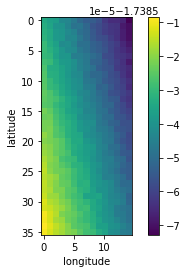

In [ ]:
#na regiao sul chove mais (amarelo)
#eixo x é longitude
#eixo y é latitude
#quando aumenta o indice vai pra esquerda (ando pra esquerda a chuva diminuiu no eixo x)
plt.imshow(array)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.show()

In [ ]:
import seaborn as sns

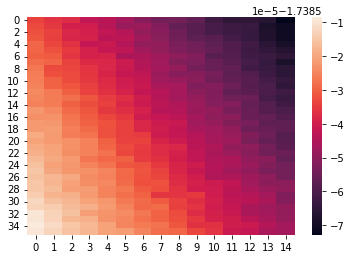

In [ ]:
sns.heatmap(array)